<a href="https://colab.research.google.com/github/shbnm93/Data-Science-Projects/blob/main/Microsoft_Stock_Forecasting_with_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

In [2]:
import pandas as pd

df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/13/1986,0.088542,0.101563,0.088542,0.097222,0.060163,1031788800
1,3/14/1986,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
2,3/17/1986,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
3,3/18/1986,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
4,3/19/1986,0.099826,0.100694,0.097222,0.098090,0.060700,47894400
...,...,...,...,...,...,...,...
9562,2/22/2024,410.190002,412.829987,408.570007,411.649994,411.649994,27009900
9563,2/23/2024,415.670013,415.859985,408.970001,410.339996,410.339996,16284800
9564,2/26/2024,411.459991,412.160004,407.359985,407.540009,407.540009,16193500
9565,2/27/2024,407.989990,408.320007,403.850006,407.480011,407.480011,14835800


In [3]:
df = df[['Date', 'Close']]

df

,Date,Close
0,3/13/1986,0.097222
1,3/14/1986,0.100694
2,3/17/1986,0.102431
3,3/18/1986,0.099826
4,3/19/1986,0.098090
...,...,...
9562,2/22/2024,411.649994
9563,2/23/2024,410.339996
9564,2/26/2024,407.540009
9565,2/27/2024,407.480011


In [4]:
df['Date']

0       3/13/1986
1       3/14/1986
2       3/17/1986
3       3/18/1986
4       3/19/1986
          ...    
9562    2/22/2024
9563    2/23/2024
9564    2/26/2024
9565    2/27/2024
9566    2/28/2024
Name: Date, Length: 9567, dtype: object

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('/')
  month, day, year = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(month=month, day=day, year=year)

datetime_object = str_to_datetime('3/13/1986')
datetime_object

datetime.datetime(1986, 3, 13, 0, 0)

In [6]:
df

,Date,Close
0,3/13/1986,0.097222
1,3/14/1986,0.100694
2,3/17/1986,0.102431
3,3/18/1986,0.099826
4,3/19/1986,0.098090
...,...,...
9562,2/22/2024,411.649994
9563,2/23/2024,410.339996
9564,2/26/2024,407.540009
9565,2/27/2024,407.480011


In [7]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-7-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9562   2024-02-22
9563   2024-02-23
9564   2024-02-26
9565   2024-02-27
9566   2024-02-28
Name: Date, Length: 9567, dtype: datetime64[ns]

In [8]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-02-22,411.649994
2024-02-23,410.339996
2024-02-26,407.540009


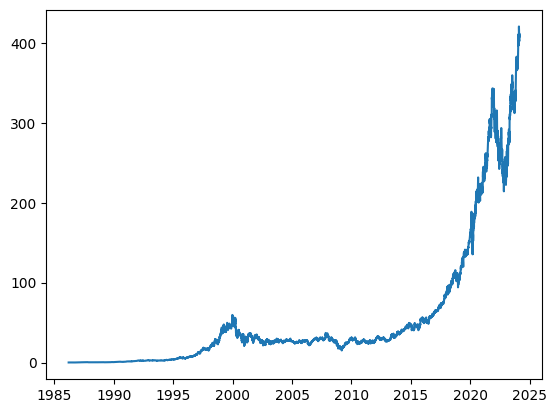

In [9]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [10]:
import numpy as np
from datetime import datetime, timedelta

# Define the str_to_datetime function
def str_to_datetime(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2024-02-28',
                                n=3)
windowed_df


,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
732,2024-02-22,404.059998,402.790009,402.179993,411.649994
733,2024-02-23,402.790009,402.179993,411.649994,410.339996
734,2024-02-26,402.179993,411.649994,410.339996,407.540009
735,2024-02-27,411.649994,410.339996,407.540009,407.480011


In [11]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((737,), (737, 3, 1), (737,))

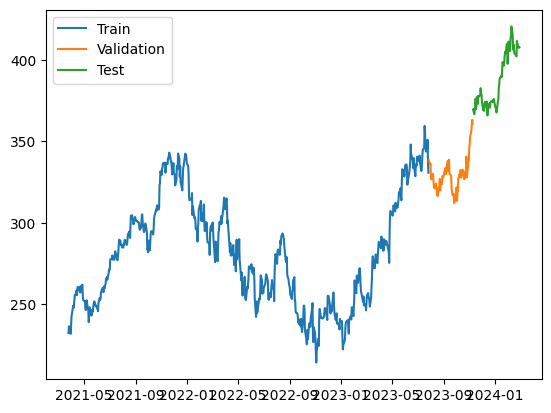

In [12]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
19/19 [==============================] - 10s 101ms/step - loss: 79887.2578 - mean_absolute_error: 280.7567 - val_loss: 108408.3672 - val_mean_absolute_error: 329.0753
Epoch 2/100
19/19 [==============================] - 0s 24ms/step - loss: 79598.7031 - mean_absolute_error: 280.2408 - val_loss: 107972.6719 - val_mean_absolute_error: 328.4126
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 79018.5312 - mean_absolute_error: 279.2026 - val_loss: 106953.5547 - val_mean_absolute_error: 326.8573
Epoch 4/100
19/19 [==============================] - 1s 53ms/step - loss: 77797.6484 - mean_absolute_error: 277.0128 - val_loss: 104941.6250 - val_mean_absolute_error: 323.7649
Epoch 5/100
19/19 [==============================] - 0s 23ms/step - loss: 75178.3984 - mean_absolute_error: 272.2286 - val_loss: 100336.4688 - val_mean_absolute_error: 316.5732
Epoch 6/100
19/19 [==============================] - 0s 16ms/step - loss: 70172.2031 - mean_absolute_error: 262.8

19/19 [==============================] - 1s 3ms/step


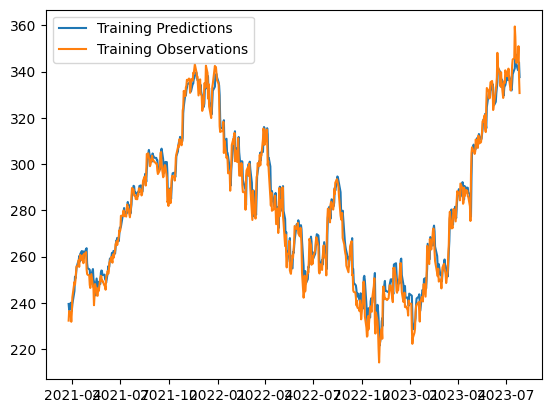

In [14]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 4ms/step


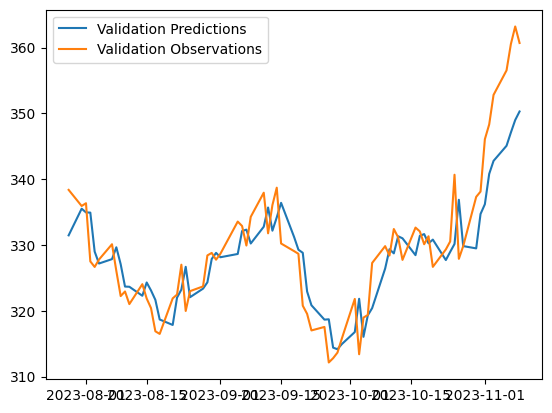

In [15]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 4ms/step


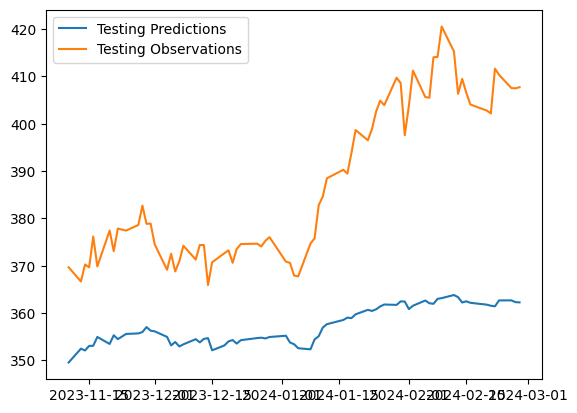

In [16]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

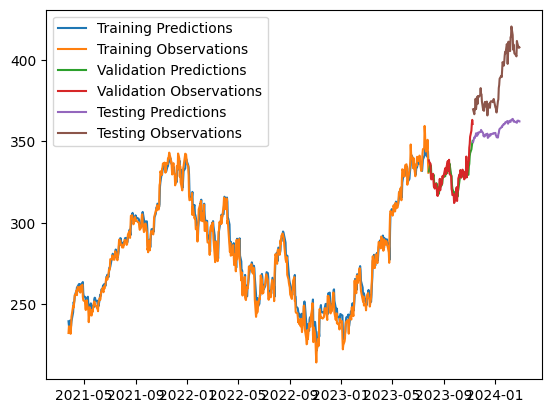

In [17]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [18]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 26ms/step


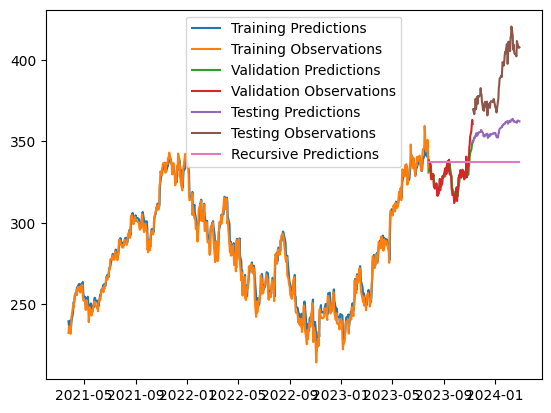

In [19]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])